In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [3]:
print('데이터 개수 =', len(data))
print('데이터 컬럼 개수 =', len(data.columns))
data.columns

데이터 개수 = 7674
데이터 컬럼 개수 = 62


Index(['지점', '지점명', '일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)',
       '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)', '최다풍향(16방위)',
       '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)',
       '평균 증기압(hPa)', '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최고 해면기압 시각(hhmi)',
       '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)', '가조시간(hr)',
       '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '일 최심신적설 시각(hhmi)', '일 최심적설(cm)', '일 최심적설 시각(hhmi)',
       '합계 3시간 신적설(cm)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)',
       '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)',
       '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0m 지중온도(°C)', '1.5m 지중온도(°C)', '3.0m 지중온

In [4]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [13]:
# 라벨값 설정
data['Y'] = data['일강수량(mm)'].shift(-2)
# 라벨값을 강수 유무로 변경
data['Y'] = data['Y'].apply(lambda X: 1 if X!=0 else 0)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#### DNN

In [28]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

DNN.compile(loss='binary_crossentropy', optimizer=optimizer)
DNN.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_29 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_30 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________

Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4560/4749 [===========================>..] - ETA: 0s - loss: 23.4714
Epoch 00001: val_loss improved from inf to 4.33618, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 103us/sample - loss: 22.7955 - val_loss: 4.3362
Epoch 2/200
4350/4749 [==========================>...] - ETA: 0s - loss: 6.2211
Epoch 00002: val_loss improved from 4.33618 to 3.99952, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 44us/sample - loss: 6.2147 - val_loss: 3.9995
Epoch 3/200
4560/4749 [===========================>..] - ETA: 0s - loss: 5.2824
Epoch 00003: val_loss did not improve from 3.99952
4749/4749 [==============================] - 0s 42us/sample - loss: 5.3572 - val_loss: 14.6109
Epoch 4/200
4350/4749 [==========================>...] - ETA: 0s - loss: 5.0766
Epoch 00004: val_loss improved from 3.99952 to 2.61914, saving model to checkpoint.keras
4749/4749 [=====================

Epoch 31/200
4530/4749 [===========================>..] - ETA: 0s - loss: 0.5981
Epoch 00031: val_loss did not improve from 0.61870

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
4749/4749 [==============================] - 0s 41us/sample - loss: 0.5974 - val_loss: 0.6187
Epoch 32/200
4590/4749 [===========================>..] - ETA: 0s - loss: 0.5960
Epoch 00032: val_loss did not improve from 0.61870

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
4749/4749 [==============================] - 0s 41us/sample - loss: 0.5974 - val_loss: 0.6187
Epoch 33/200
4530/4749 [===========================>..] - ETA: 0s - loss: 0.5972
Epoch 00033: val_loss did not improve from 0.61870

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.000000045813705e-19.
4749/4749 [==============================] - 0s 41us/sample - loss: 0.5974 - val_loss: 0.6187


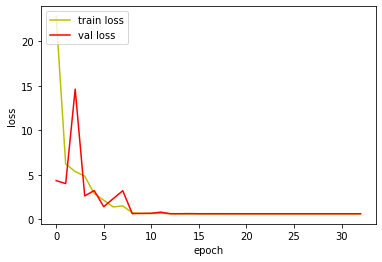

In [29]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = DNN.fit(trainX,trainY, validation_data=(validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### RNN  
RNN의 경우 입력 데이터 형태가 3차원이 되어야 한다.  
input shape = (Batch size, timesteps, input_dim)  
Bath size는 한번에 학습되는 데이터 개수  
timesteps는 데이터의 시퀀스 길이  
input_dim은 feature 개수  
이다  

In [30]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=True)(inputs_1)
rnn = tf.keras.layers.SimpleRNN(100, return_sequences=False)(rnn)
output = tf.keras.layers.Dense(1,activation='sigmoid')(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='binary_crossentropy', optimizer=optimizer)
RNN.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 100)            14500     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 34,701
Trainable params: 34,701
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4560/4749 [===========================>..] - ETA: 0s - loss: 0.6239
Epoch 00001: val_loss improved from inf to 0.62517, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 276us/sample - loss: 0.6230 - val_loss: 0.6252
Epoch 2/200
4530/4749 [===========================>..] - ETA: 0s - loss: 0.6207
Epoch 00002: val_loss improved from 0.62517 to 0.61615, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 75us/sample - loss: 0.6206 - val_loss: 0.6162
Epoch 3/200
4080/4749 [========================>.....] - ETA: 0s - loss: 0.6174
Epoch 00003: val_loss did not improve from 0.61615
4749/4749 [==============================] - 0s 71us/sample - loss: 0.6200 - val_loss: 0.6215
Epoch 4/200
4560/4749 [===========================>..] - ETA: 0s - loss: 0.6162
Epoch 00004: val_loss did not improve from 0.61615
4749/4749 [==============================] - 0s 66us/sample - loss: 0.615

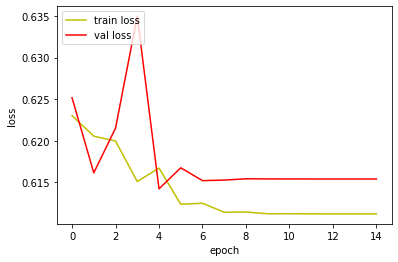

In [31]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### LSTM  
LSTM도 RNN과 같이 입력 데이터 형태가 3차원이 되어야 한다.  
input shape = (Batch size, timesteps, input_dim)  

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1, 44)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            58000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 138,501
Trainable params: 138,501
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4260/4749 [=========================>....] - ETA: 0s - loss: 0.6145
Epoch 00001: val_loss improved from inf to 0.61238, saving model to checkpoint.keras
4749/4749 [===========================

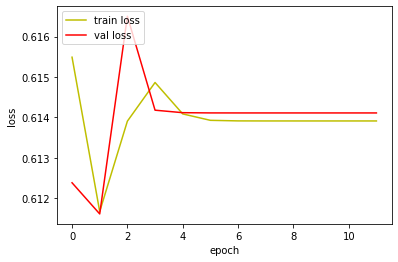

In [32]:
inputs_1 = tf.keras.Input(shape=(1,44))
lstm = tf.keras.layers.LSTM(100, return_sequences=True)(inputs_1)
lstm = tf.keras.layers.LSTM(100, return_sequences=False)(lstm)
output = tf.keras.layers.Dense(1,activation='sigmoid')(lstm)

LSTM = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

LSTM.compile(loss='binary_crossentropy', optimizer=optimizer)
LSTM.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = LSTM.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_DNN =  0.38776805740048553
MAE_RNN =  0.41542511558728407
MAE_LSTM =  0.4178258905801336


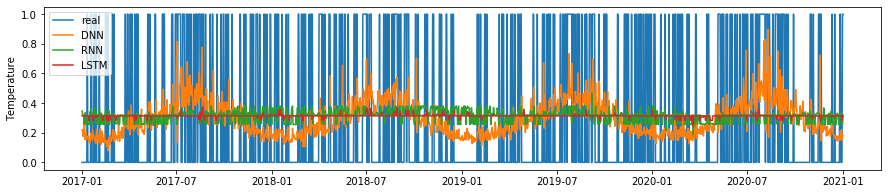

In [33]:
time = pd.to_datetime(test['일시'])

pred_DNN = DNN.predict(testX)
pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)
pred_LSTM = LSTM.predict(testX.values.reshape(-1,1,44))


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_DNN)
plt.plot(time,pred_RNN)
plt.plot(time,pred_LSTM)

plt.ylabel('Temperature')
plt.legend(['real','DNN','RNN','LSTM'])

print('MAE')
print('MAE_DNN = ',(((testY-pred_DNN.reshape(-1,))**2)**0.5).mean())
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())
print('MAE_LSTM = ',(((testY-pred_LSTM.reshape(-1,))**2)**0.5).mean())

강수 유무를 예측한 것이므로 예측 성능을 평가하는 지표를 변경하여야 한다.  
먼저 간단한게 accuracy만 계산하도록 하자  
output layer의 활성화함수를 시그모이드로 설정하여 0-1사이 값만 출력하도록 하였다.  
0.5 이상은 1, 0.5 미만은 0으로 변경하여 클래스로 분리해준다.  

In [44]:
pred_DNN = [1 if i[0]>=0.5 else 0 for i in pred_DNN]
pred_RNN = [1 if i>=0.5 else 0 for i in pred_RNN]
pred_LSTM = [1 if i>=0.5 else 0 for i in pred_LSTM]

In [35]:
def cal_acc(pred):
    for i,j in zip(testY,pred):
        if i==j

array([[0.22086513],
       [0.22023726],
       [0.17511858],
       ...,
       [0.14904398],
       [0.17533661],
       [0.17997739]], dtype=float32)

In [49]:
for i,j in zip(testY,pred_DNN):
    print(i,j)

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
1 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 1
0 0
0 0
0 0
0 0
1 0
1 0
1 1
1 1
0 0
1 0
1 0
1 0
1 1
1 1
1 1
0 1
0 0
0 0
1 0
1 1
1 1
1 0
0 1
0 0
0 0
1 0
1 0
1 1
0 0
0 1
1 0
1 0
0 1
0 1
1 0
1 0
0 1
0 0
0 0
0 0
1 0
0 0
0 0
1 0
1 1
1 1
0 1
0 0
1 0
1 1
1 1
1 0
0 0
0 0
1 0
1 1
0 0
1 0
1 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
